## Programming Exercise 4: Neural Networks Learning

#### Setup

In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import Image

data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')

In [7]:
# Padded with the ones at the beggining
X, y = np.c_[np.ones((data['X'].shape[0],1)), data['X']], data['y'] 
# Showing that the weights contains theta1 and theta2
weights.keys()

['Theta2', '__version__', '__header__', 'Theta1', '__globals__']

#### Displaying the Data

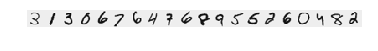

In [8]:
rand_indices = np.random.choice(X.shape[0], 20)
sel1 = X[rand_indices[0:20], 1:].reshape(-1,20).T

plt.imshow(sel1, cmap='gray_r')
plt.axis('off')
plt.show()

#### Model Representation
Taken from the assignment's documentation:

![Model](img/Neural_Network_Model.png)

#### Feedforward and cost function

In [18]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def nn_ff_cost_function(nn_params, num_labels, X, y, reg):
    
    # Extracting the Thetas
    theta1 = nn_params['Theta1']
    theta2 = nn_params['Theta2']
    
    # Setuping some variables
    m = X.shape[0]
    J = 0
    theta1_grad = np.zeros((theta1.shape))
    theta2_grad = np.zeros((theta2.shape))
    
    # Regularization Function
    ## Empty for Now
    
    # FF neural network
    ## Since X is already padded with 1 we don't need to add ones
    a1 = X 
    ## Calculating the Hidden Layer
    a2 = sigmoid(X.dot(theta1.T))
    ## Then adding 1s
    a2 = np.c_[np.ones((a2.shape[0],1)), a2]
    ## Calculating the hypothesis
    h_thx = sigmoid(a2.dot(theta2.T))
    
    # Calculating the Cost Function
    for label in xrange(num_labels):
        y_label = y == label + 1 # since python indexing starts from 0
        h = h_thx[:,label].reshape(-1,1)
        J_label = - 1. / m * (y_label.dot(np.log(h).T) - (1 - y_label).dot(np.log(1 - h).T))
        J = J + J_label
        
    return h_thx
        


# Temp test
test = nn_ff_cost_function(weights, 10, X, y, 0)
print test[:,3].shape

(5000,)


In [10]:
print weights['Theta1'].shape, weights['Theta2'].shape, X.shape

(25, 401) (10, 26) (5000, 401)


In [11]:
a1 = sigmoid(X.dot(weights['Theta1'].T))
print a1.shape
a2 = sigmoid(np.c_[np.ones((a1.shape[0],1)), a1].dot(weights['Theta2'].T))
print a2.shape

(5000, 25)
(5000, 10)
